Ejercicio de síntesis de los temas: raíces, interpolación/aproximación, cuadratura/derivación, ecuaciones diferenciales ordinarias

Por Pablo Angulo y Fabricio Macià para ETSIN@UPM

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import scipy.linalg as la
import scipy.integrate as integ
from scipy.optimize import root, bisect
from scipy.interpolate import lagrange, CubicSpline

# Gestión de recursos pesqueros

La siguiente ecuación diferencial describe el comportamiento de una especie de interés pesquero, bajo un cierto esfuerzo pesquero proporcional al tamaño de la población $x(t)$ (los números son ficticios):
$$
\begin{split}
\dot{x(t)}&= \alpha x(t) \left(1 - \frac{x(t)}{K}\right) - \phi x(t)
\end{split}
$$
donde
 - $\alpha = 0.3$ es la capacidad de regeneración de la población
 - $\phi=0.25$ es el esfuerzo pesquero
 - $K=10$ es el tamaño máximo de población que admite el ecosistema

El tamaño de la población $x(t)$, debe estar entre $0$ y $K$.

### Apartado 1

Resuelve de forma aproximada el PVI correspondiente al problema anterior, cuando $x(0)=1$, usando el método de Euler, en el intervalo de tiempo $[0,60]$, con paso $h=6$.

In [2]:
def euler(f, y0, t0, tf, N):
    'version vectorial del método de Euler'
    h = (tf - t0)/N
    ts = np.linspace(t0, tf, N+1)
    tj = 0
    #admitimos que el argumento y0 sea "list", pero lo convertimos a array
    #np.array tb hace una copia, para que no modifiquemos el original
    yj = np.array(y0)
    d = yj.shape[0]
    ys = np.zeros((d,N+1))
    for j in range(N+1):
        ys[:,j] = yj
        yj = yj + h*f(tj, yj)
        tj = tj + h
    return ts, ys

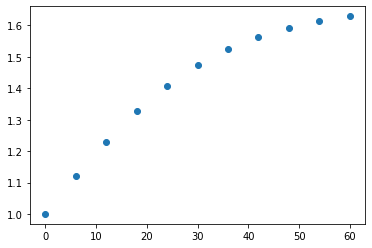

In [3]:
a = 0.3
fishing = 0.25
K = 10

def dydt(t, y):
    return a*y*(1 - y/K) - fishing*y

t0,tf = [0,60]
t_span = [t0, tf]
y0 = [1]


ntimes = 10
ts, ys = euler(dydt, y0, t0, tf, ntimes)
plt.plot(ts, ys[0,:], 'o')

### Apartado 2

Interpola los valores obtenidos en el método anterior usando el polinomio de Lagrange, y la spline cúbica.
Estima el máximo de la diferencia entre el resultado de interpolar con uno y otro método, en el intervalo $[0,60]$.

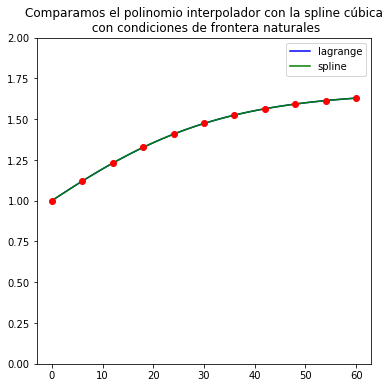

In [4]:
T = ts[-1]
fish = ys[0,:]

t_eval = np.linspace(0,T,100)

l = lagrange(ts, fish)
ys1 = l(t_eval)
#Alternativa: polyfit tb puede calcular el polinomio interpolador
# si el grado del polinomio es igual al número de puntos menos 1
# Además, polyfit es más estable que lagrange
coefs = np.polyfit(ts, fish, len(ts)-1)
ys1 = np.polyval(coefs, t_eval)

cs = CubicSpline(ts, fish, bc_type='natural')
ys2 = cs(t_eval)

plt.figure(figsize=(6,6))
plt.plot(t_eval, ys1, 'b', label='lagrange')
plt.plot(t_eval, ys2, 'g', label='spline')
plt.plot(ts, fish, 'or')
#ax.axhline(c='k')
plt.ylim(0,2)
plt.title('Comparamos el polinomio interpolador con la spline cúbica\n'
             ' con condiciones de frontera naturales')
plt.legend()
plt.show()

In [5]:
print('Máxima diferencia entre el polinomio de Lagrange y la spline cúbica', 
      max(abs(ys1-ys2)))

Máxima diferencia entre el polinomio de Lagrange y la spline cúbica 0.0002357029468400551


### Apartado 3

Repite el ejercicio anterior usando un método adaptativo (`solve_ivp` en `scipy.integrate`), con los puntos elegidos por el método adaptativo.

- Usamos el método Runge-Kuta (4,5) , que usa un método de orden 4 para avanzar, y un método de orden 5 para estimar el error y elegir el tamaño del paso adecuado para cada región del intervalo de integración.

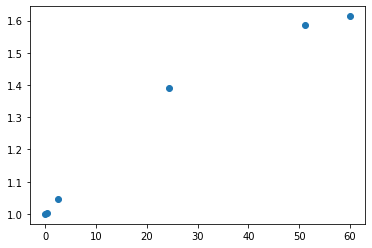

In [8]:
t_span = [t0, tf]
sol = integ.solve_ivp(
    dydt, t_span, y0, 
    method='RK45'
)

ts = sol['t']
ys = sol['y']
plt.plot(ts, ys[0,:], 'o')

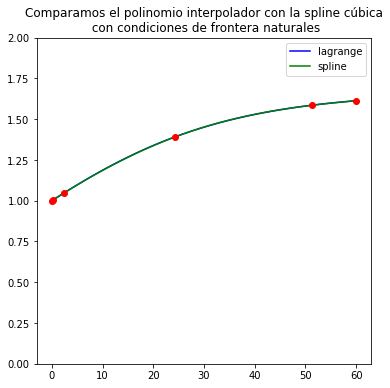

In [9]:
T = ts[-1]
fish = ys[0,:]

t_eval = np.linspace(0,T,100)
coefs = np.polyfit(ts, fish, len(ts)-1)
ys1 = np.polyval(coefs, t_eval)

cs = CubicSpline(ts, fish, bc_type='natural')
ys2 = cs(t_eval)

plt.figure(figsize=(6,6))
plt.plot(t_eval, ys1, 'b', label='lagrange')
plt.plot(t_eval, ys2, 'g', label='spline')
plt.plot(ts, fish, 'or')
#ax.axhline(c='k')
plt.ylim(0,2)
plt.title('Comparamos el polinomio interpolador con la spline cúbica\n'
             ' con condiciones de frontera naturales')
plt.legend()
plt.show()

In [10]:
print('Máxima diferencia entre el polinomio de Lagrange y la spline cúbica', 
      max(abs(ys1-ys2)))

Máxima diferencia entre el polinomio de Lagrange y la spline cúbica 0.001155686325111649


### Apartado 4

La ecuación diferencial anterior no depende de forma explícita del tiempo y por lo tanto define un sistema dinámico autónomo.

Encuentra _todos_ los puntos de equilibrio del sistema dinámico anterior para los siguientes valores de la intensidad pesquera: $\phi = 0.1, 0.2, 0.4$. Usa el método de bisección para acotar cada punto de equilibrio.

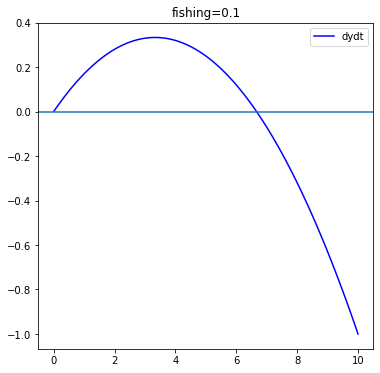

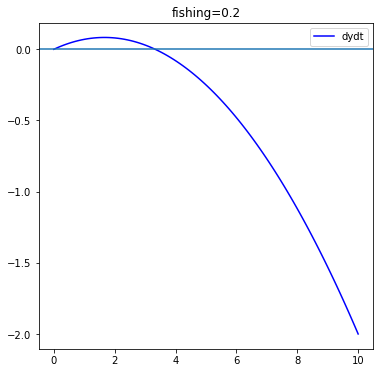

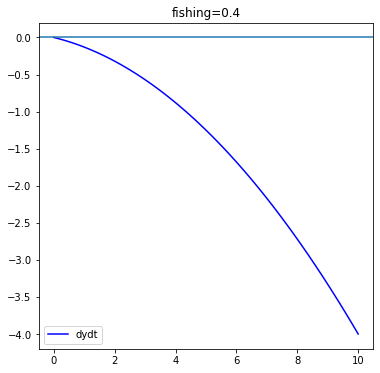

In [11]:
for fishing in (0.1, 0.2, 0.4):
    def f(y):
        return a*y*(1 - y/K) - fishing*y

    fig = plt.figure(figsize=(6,6))
    y_eval = np.linspace(0,K,100)
    dy_eval = f(y_eval)
    plt.plot(y_eval, dy_eval, 'b', label='dydt')
    plt.title('fishing=%s'%fishing)
    plt.axhline()
    plt.legend()
    plt.show()

- Para $\phi=0.1,0.2$ hay dos equilibrios, que podemos acotar entre un valor positivo muy pequeño (1e-3, por ejemplo) y el tamaño maximo de la población $K$.
- Para $\phi=0.4$ parece que sólo tenemos el equilibrio $x=0$ en el intervalo $[0,K]$. No nos interesan otros equilibrios que corresponden a valores negativos de la población... 

In [12]:
for fishing in (0.1, 0.2):
    def f(y):
        return a*y*(1 - y/K) - fishing*y

    res = bisect(f, 0.001,20)
    print('phi:', fishing, ' ; y_equilibrio:', res)

phi: 0.1  ; y_equilibrio: 6.666666666667718
phi: 0.2  ; y_equilibrio: 3.3333333333337927


### Apartado 5

La cantidad total pescada en el intervalo $[0,T]$ es igual a $\int_0^T\phi y(t)\;dt$.

Calcula de forma aproximada la cantidad total pescada utilizando un método de cuadratura, para los siguientes valores de la intensidad pesquera: $\phi = 0.05, 0.1, 0.15, 0.2, 0.25$.

*Pista*: Antes de llamar al método de cuadratura, es conveniente obtener valores de $y$ en una serie de puntos equiespaciados, y para ello puedes usar cualquier método de interpolación, pero también los atributos ``t_eval`` en ``solve_ivp``.

> `t_eval` : array_like or None, optional
>    Times at which to store the computed solution, must be sorted and lie
>    within `t_span`. If None (default), use points selected by the solver.

 - Obtenemos una serie de valores de la población $y$ para una serie de tiempos equiespaciados.
 - Usamos el método de Simpson, que devuelve una aproximación a la integral cuando tenemos una serie de datos $\{t_i, y_i\}$ equiespaciados.
 - Observamos que el mayor rendimiento se obtiene cuando $\phi=0.15$

In [13]:
for fishing in (0.05,0.1,0.15,0.2,0.25):

    def dydt(t, y):
        return a*y*(1 - y/K) - fishing*y

    t0,tf = t_span = [0,60]
    y0 = [1]
    #Usamos 100 puntos equiespaciados
    nframes = 200
    ts = np.linspace(t0, tf, nframes)

    sol = integ.solve_ivp(
        dydt, t_span, y0, 
        method='RK45',
        t_eval=ts
    )
    #Integramos y con el método de Simpson
    p = fishing*integ.simps(sol['y'][0,:], sol['t'])
        
    print('phi:', fishing, ' ; total pesca:', p)

phi: 0.05  ; total pesca: 21.46760428621249
phi: 0.1  ; total pesca: 33.67952757696103
phi: 0.15  ; total pesca: 36.958521411258076
phi: 0.2  ; total pesca: 32.01493306413086
phi: 0.25  ; total pesca: 21.017146965426495


- A modo de curiosidad, comparamos el total pescado con el resultado de la siguiente operación: $\phi (t_f-t_0) y_{eq}$, donde $(t_f-t_0)$ es la longitud del intervalo temporal considerado, y $y_{eq}$ es el valor de equilibro para la población a ese nivel de intensidad pesquera:
- _En este modelo, la cantidad total pescada es igual a este número, salvo por un periodo de transición al equilibrio._

In [14]:
for fishing in (0.05,0.1,0.15,0.2,0.25):

    def dydt(t, y):
        return a*y*(1 - y/K) - fishing*y

    t0,tf = t_span = [0,60]
    y0 = [1]
    #Usamos 100 puntos equiespaciados
    nframes = 100
    ts = np.linspace(t0, tf, nframes)

    sol = integ.solve_ivp(
        dydt, t_span, y0, 
        method='RK45',
        t_eval=ts
    )
    #Integramos y con el método de Simpson
    p = fishing*integ.simps(sol['y'][0,:], sol['t'])
    def f(y):
        return a*y*(1 - y/K) - fishing*y

    res = bisect(f, 0.001,20)
    print('phi:', fishing, 
          ' ; phi*Delta_t*y_equilibrio:', fishing*res*tf, 
          ' ; total pesca:', p)

phi: 0.05  ; phi*Delta_t*y_equilibrio: 24.99999999999721  ; total pesca: 21.46762210585831
phi: 0.1  ; phi*Delta_t*y_equilibrio: 40.00000000000631  ; total pesca: 33.67954719727547
phi: 0.15  ; phi*Delta_t*y_equilibrio: 45.00000000000679  ; total pesca: 36.958534596920664
phi: 0.2  ; phi*Delta_t*y_equilibrio: 40.000000000005514  ; total pesca: 32.01493735120826
phi: 0.25  ; phi*Delta_t*y_equilibrio: 25.00000000000247  ; total pesca: 21.017146300140666


- *Disclaimer*: todos los apartados anteriores se podían resolver de forma exacta, la ecuación planteada es la "ecuación logística". Sin embargo, si introducimos varias especies en nuestro modelo, no es tan fácil encontrar una solución exacta...

## Modelo depredador-presa

El siguiente sistema de ecuaciones describe el comportamiento de dos especies, depredador ($y$) y presa ($x$), bajo un cierto esfuerzo pesquero de la especie depredadora proporcional al tamaño de la población:
$$
\begin{split}
\dot{x}(t)&= \alpha x(t) \left(1 - \frac{x(t)}{K}\right) - \beta x(t) y(t)\\
\dot{y}(t)&= \delta x(t) y(t) - \gamma y(t) - \phi y(t)
\end{split}
$$
donde $\alpha = 0.3, \beta=0.2, \delta=0.1, \gamma=0.2, \phi=0.1, K=10$.

### Apartado 6

Resuelve usando un método adaptativo el PVI correspondiente al problema anterior, para $x(0)=1, y(0)=0.5$, en el intervalo de tiempo $[0,60]$.

- Los puntos obtenidos son pocos, porque el método Runge-Kuta 4,5 estima que el error cometido es lo bastante bajo, y no necesita disminuir el paso.

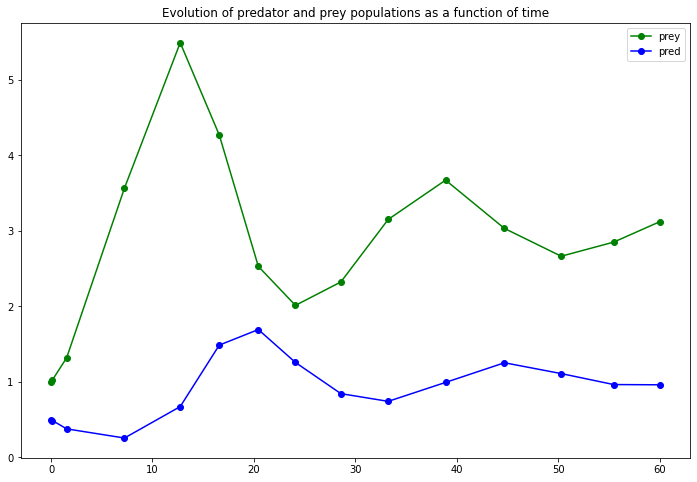

In [15]:
a, b, c, d = .3, .2, .2, .1
K = 10

fishing = .1

def DP(t,ys):
    prey, pred = ys
    return [
        a*prey*(1 - prey/K) - b*pred*prey, #rate of change of prey
        -pred*(c - d*prey) - fishing*pred#rate of change of predator
    ]


t0,tf = t_span = [0,60]
y0 = [1,0.5]

sol = integ.solve_ivp(
    DP, t_span, y0, 
    method='RK45'
)

plt.figure(figsize=(12,8))
plt.plot(sol['t'], sol['y'][0,:], 'o-g', label='prey')
plt.plot(sol['t'], sol['y'][1,:], 'o-b', label='pred')
plt.title('Evolution of predator and prey populations as a function of time')
plt.legend()

### Apartado 7


Interpola los valores obtenidos en el método anterior para la población de depredadores usando el polinomio de Lagrange, y la spline cúbica.
Estima el máximo de la diferencia entre el resultado de interpolar con uno y otro método, en el intervalo $[0,60]$.

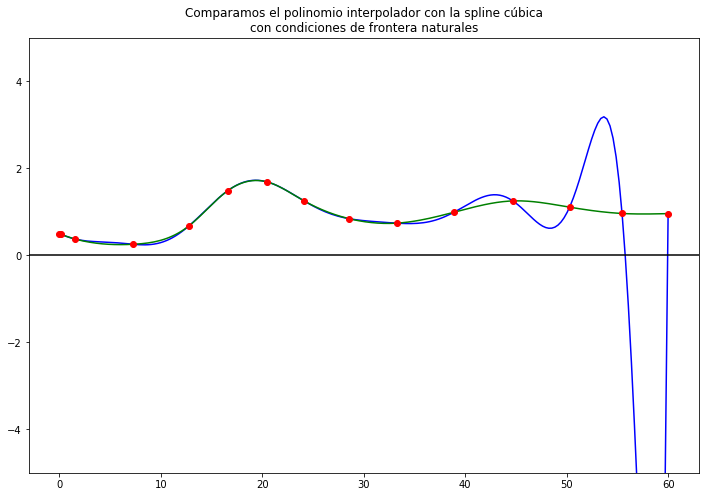

In [16]:
KK=15

sol = integ.solve_ivp(
    DP, t_span, y0, 
    method='RK45', 
)

ts = sol['t'][:KK]
prey = sol['y'][0,:][:KK]
pred = sol['y'][1,:][:KK]
T = ts[-1]

l = lagrange(ts, pred)
cs = CubicSpline(ts, pred, bc_type='natural')

xs = np.linspace(0,T,200)
ys1 = l(xs)
ys2 = cs(xs)
plt.figure(figsize=(12,8))
plt.plot(xs, ys1, 'b')
plt.plot(xs, ys2, 'g')
plt.plot(ts, pred, 'or')
plt.axhline(c='k')
plt.ylim(-5,5)
plt.title('Comparamos el polinomio interpolador con la spline cúbica\n'
              'con condiciones de frontera naturales')
plt.show()

 - Vemos que el polinomio de Lagrange interpola de una forma claramente errónea.

In [17]:
print('Máxima diferencia entre el polinomio de Lagrange y la spline cúbica', 
      max(abs(ys1-ys2)))

Máxima diferencia entre el polinomio de Lagrange y la spline cúbica 13.413205177448402


- A modo de curiosidad, comprobamos que la spline cúbica devuelve resultados similares a la interpolación "de serie" del método `'RK45'` de `solve_ivp`. Según la documentación _"A quartic interpolation polynomial is used for the dense output"_.

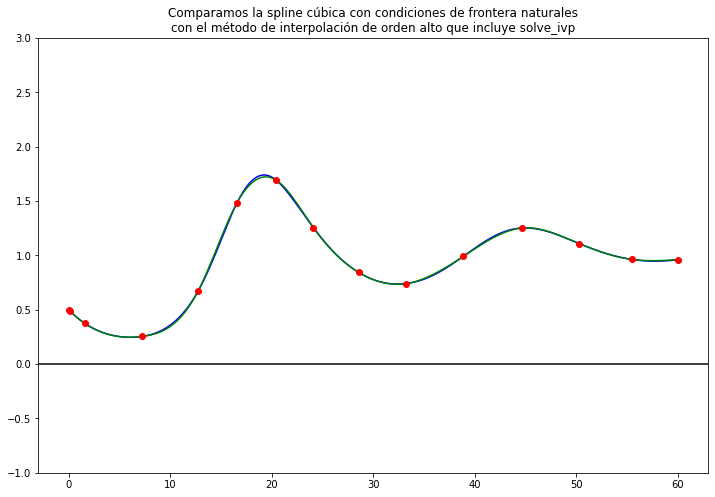

In [18]:
KK=15

sol = integ.solve_ivp(
    DP, t_span, y0, 
    method='RK45', 
)
ts200 = np.linspace(t0, tf, 200)
sol2 = integ.solve_ivp(
    DP, t_span, y0, 
    method='RK45', 
    t_eval=ts200
)


ts = sol['t'][:KK]
prey = sol['y'][0,:][:KK]
pred = sol['y'][1,:][:KK]
T = ts[-1]

cs = CubicSpline(ts, pred, bc_type='natural')

plt.figure(figsize=(12,8))
ys1 = sol2['y'][1,:]
ys2 = cs(ts200)
plt.plot(ts200, ys1, 'b')
plt.plot(ts200, ys2, 'g')
plt.plot(ts, pred, 'or')
plt.axhline(c='k')
plt.ylim(-1,3)
plt.title('Comparamos la spline cúbica con condiciones de frontera naturales\n'
             'con el método de interpolación de orden alto que incluye solve_ivp')
plt.show()

In [19]:
print('Máxima diferencia entre la spline cúbica y la interpolación de serie de solve_ivp', 
      max(abs(ys1-ys2)))

Máxima diferencia entre la spline cúbica y la interpolación de serie de solve_ivp 0.023154099823738727


### Apartado 8

Busca puntos de equilibrio del sistema dinámico anterior para los siguientes valores del esfuerzo pesquero: $\phi = 0.1, 0.2, 0.3$. Evita el punto de equilibrio trivial $x=y=0$.

 - No podemos usar el método de bisección, tenemos que dar al método ``root`` un punto de partida y probar varios métodos que no hemos estudiado en teoría. Es importante evitar el equilibrio trivial $(0,0)$, así que partimos de un punto inicial alejado, y probamos varios métodos para ver cuál encuentra el equilibrio que buscamos...

In [20]:
root?

Signature:
root(
    fun,
    x0,
    args=(),
    method='hybr',
    jac=None,
    tol=None,
    callback=None,
    options=None,
)
Docstring:
Find a root of a vector function.

Parameters
----------
fun : callable
    A vector function to find a root of.
x0 : ndarray
    Initial guess.
args : tuple, optional
    Extra arguments passed to the objective function and its Jacobian.
method : str, optional
    Type of solver. Should be one of

        - 'hybr'             :ref:`(see here) <optimize.root-hybr>`
        - 'lm'               :ref:`(see here) <optimize.root-lm>`
        - 'broyden1'         :ref:`(see here) <optimize.root-broyden1>`
        - 'broyden2'         :ref:`(see here) <optimize.root-broyden2>`
        - 'anderson'         :ref:`(see here) <optimize.root-anderson>`
        - 'linearmixing'     :ref:`(see here) <optimize.root-linearmixing>`
        - 'diagbroyden'      :ref:`(see here) <optimize.root-diagbroyden>`
        - 'excitingmixing'   :ref:`(see here) <optimize

In [22]:
a, b, c, d = .3, .2, .2, .1
K = 10
fishing = 0.1

def DP_stat(ys):
    prey, pred = ys
    return [
        a*prey*(1 - prey/K) - b*pred*prey, #rate of change of prey
        -pred*(c - d*prey) - fishing*pred#rate of change of predator
    ]

root(DP_stat, [1,1], method='lm')

   cov_x: array([[ 90.70294676, -13.60544248],
       [-13.60544248,   4.81859419]])
    fjac: array([[ 6.00000003e-01,  1.47828979e-09],
       [ 9.00000035e-02, -1.05000001e-01]])
     fun: array([-2.22044605e-16,  2.77555756e-17])
    ipvt: array([2, 1], dtype=int32)
 message: 'The relative error between two consecutive iterates is at most 0.000000'
    nfev: 20
     qtf: array([-2.13671081e-10,  1.46444801e-10])
  status: 2
 success: True
       x: array([3.  , 1.05])

- Dibujamos un diagrama de fases con el comportamiento de depredador y presa, y los puntos de equilibrio que acabamos de calcular, para varios valores de la intensidad pesquera.

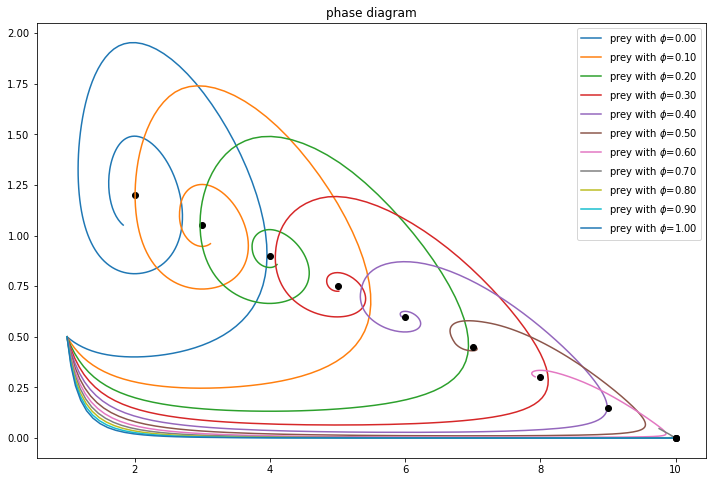

In [24]:
a, b, c, d = .3, .2, .2, .1
K = 10
plt.figure(figsize=(12,8))

for fishing in np.linspace(0,1,11):

    def DP(t,ys):
        prey, pred = ys
        return [
            a*prey*(1 - prey/K) - b*pred*prey, #rate of change of prey
            -pred*(c - d*prey) - fishing*pred#rate of change of predator
        ]

    t0,tf = t_span = [0,60]
    #y0 = [np.pi/2,0]
    y0 = [1,0.5]
    nframes = 200
    ts = np.linspace(t0, tf, nframes)

    sol = integ.solve_ivp(
        DP, t_span, y0, 
        method='RK45',
        t_eval=ts
    )

    plt.plot(sol['y'][0,:], sol['y'][1,:], label='prey with $\\phi$=%.2f'%fishing)
    
    def DP_stat(ys):
        prey, pred = ys
        return [
            a*prey*(1 - prey/K) - b*pred*prey, #rate of change of prey
            -pred*(c - d*prey) - fishing*pred#rate of change of predator
        ]
    
    res = root(DP_stat, [1,1], method='hybr')
    rx = res['x']
    plt.plot(rx[0], rx[1], 'ko')
    
plt.title('phase diagram')
plt.legend()
plt.show()